In [ ]:
import os
import sqlite3
import random
import string
import time
import sys

publishing_parameters = {
    "fragmentation": 100, # number of fragments
    "segmentation": 100 # segment size in bytes
}

In [81]:
pwd

'/home/jovyan'

Initialising database

In [82]:
def init_database():
    if not os.path.exists('dataset.db'):
        conn = sqlite3.connect('dataset.db')
        c = conn.cursor()
        c.execute('''CREATE TABLE stocks (date text)''')
        for i in range(10000000):
            c.execute("INSERT INTO stocks VALUES ('"+str(i)+"')")
        conn.commit()
        conn.close()
    else:
        print("Main dataset already exists")
# init_database()

Fragmentation

In [83]:
def fragment_database():
    if not os.path.exists('fragments'):
        os.makedirs('fragments')
        conn = sqlite3.connect('dataset.db')
        c = conn.cursor()
        c.execute("SELECT * FROM stocks")
        rows = c.fetchall()
        conn.close()

        rows_per_fragment = int(len(rows)/100)
        i=0
        while(len(rows)>0):
            i+=1
            fragment = rows[:rows_per_fragment]
            # add zeroes padding to fragment number, make it 6 digits
            conn = sqlite3.connect('fragments/fragment_'+str(i).zfill(6)+'.db')
            c = conn.cursor()
            c.execute('''CREATE TABLE stocks (date text)''')
            for row in fragment:
                c.execute("INSERT INTO stocks VALUES ('"+row[0]+"')")
            conn.commit()
            conn.close()
            rows = rows[rows_per_fragment:]
# fragment_database()

Segmentation

In [84]:
def segment_file(filename, destination, segment_size):
    # segment size in kilobytes
    segment_size = segment_size * 1024
    # read file in batches of segment size, write to new files
    file = open(filename, "rb")
    # read segment_size bytes
    i = 0
    while True:
        i+=1
        data = file.read(segment_size)
        if not data:
            break
        # write data to new file
        new_file = open(destination+"_"+str(i).zfill(6), "wb")
        new_file.write(data)
        new_file.close()


def segment_database():
    # segment the fragments into smaller segments
    if not os.path.exists("segments"):
        os.makedirs("segments")
    else:
        print("Segments already exist")
        return
    fragments = os.listdir("fragments")
    # add zero padding to filenames
    for fragment in fragments:
        segment_file("fragments/"+fragment, 'segments/'+fragment, 100);
# segment_database()

Database Reconstruction

In [85]:
def reconstruct_database():
    conn = sqlite3.connect('reconstructed.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE stocks (date text)''')
    segments = os.listdir("segments")
    # make a directory for reconstructed fragments
    if not os.path.exists("reconstructed_fragments"):
        os.makedirs("reconstructed_fragments")
    else:
        print("Reconstructed fragments already exist")
        return
    # sort the segments by name
    # names are without prefix zeroes, so they will not be sorted correctly
    # use numbers after the underscore as int to sort
    segments.sort()
    for segment in segments:
        fragment = segment.split("_")[1]
        segment_file = open("segments/"+segment, "rb")
        # copy entire segment to reconstructed fragments
        lines = segment_file.readlines()
        segment_file.close()
        # append the lines to fragment file
        fragment_file = open("reconstructed_fragments/fragment_"+fragment, "ab")
        for line in lines:
            fragment_file.write(line)
        fragment_file.close()


    # reconstruct fragments, then reconstruct the main database
    # for segment in segments:
    #     # fragment name is the first part of the segment name
    #     # fragment_<fragment_number>.db_<segment_number>.db
    #     # fragment number can be more than one digit
    #     fragment = segment.split("_")[1]
    #     segment_file = open("segments/"+segment, "rb")
    #     lines = segment_file.readlines()
    #     segment_file.close()
    #     # append the lines to fragment file
    #     fragment_file = open("reconstructed_fragments/fragment_"+fragment, "ab")
    #     for line in lines:
    #         fragment_file.write(line)
    #     fragment_file.close()
    # reconstruct the main database
    reconstructed_fragments = os.listdir("reconstructed_fragments")
    reconstructed_fragments.sort()
    for fragment in reconstructed_fragments:
        # ignore journal files
        if "journal" in fragment:
            continue
        # fragment_file = open("reconstructed_fragments/"+fragment, "rb")
        # file is a sqlite3 database
        print("reconstructed_fragments/"+fragment)
        t_conn = sqlite3.connect("reconstructed_fragments/"+fragment)
        t_c = t_conn.cursor()
        t_c.execute("SELECT * FROM stocks")
        rows = t_c.fetchall()
        t_conn.close()
        # append the rows to the main database
        for row in rows:
            c.execute("INSERT INTO stocks VALUES ('"+row[0]+"')")
    conn.commit()
    conn.close()
# reconstruct_database()

In [86]:
# Testing peer to peer vs client server
simulation_scenarios = {
    "llama": {
        "download_size": 4000, #mb
        "main_server_throughput": 1000, #mbps
        "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
        "p2p_max_clients": 350000000,
        "p2p_client_throughput_range": [1, 100], #mbps
        "p2p_average_throughput": 50, #mbps
        "daily_new_clients": 1000000,
        "average_client_lifespan": 5*24*60*60, #secondsber of days the client will seed the data once it has downloaded all of it
        "average_share_ratio": 1.5,
    },
    "medium_demand": {
        "download_size": 4000, #mb
        "main_server_throughput": 1000, #mbps
        "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
        "p2p_max_clients": 350000000,
        "p2p_client_throughput_range": [1, 100], #mbps
        "p2p_average_throughput": 50, #mbps
        "daily_new_clients": 100000,
        "average_client_lifespan": 5*24*60*60, #secondsber of days the client will seed the data once it has downloaded all of it
        "average_share_ratio": 1.5,
    },
    "kaggle2": {
        "download_size": 150, #mb
        "main_server_throughput": 10, #mbps
        "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
        "p2p_max_clients": 780000,
        "p2p_client_throughput_range": [1, 100], #mbps
        "p2p_average_throughput": 50, #mbps
        "daily_new_clients": 10000,
        "average_client_lifespan": 5*24*60*60, #seconds
        "average_share_ratio": 1.5,
    },
    "kaggle": {
        "download_size": 150, #mb
        "main_server_throughput": 1000, #mbps
        "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
        "p2p_max_clients": 780000,
        "p2p_client_throughput_range": [1, 100], #mbps
        "p2p_average_throughput": 50, #mbps
        "daily_new_clients": 500,
        "average_client_lifespan": 5*24*60*60, #seconds
        "average_share_ratio": 1.5,
    },
    "low_demand": {
        "download_size": 100000, #mb
        "main_server_throughput": 1000, #mbps
        "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
        "p2p_max_clients": 100000,
        "p2p_client_throughput_range": [1, 100], #mbps
        "p2p_average_throughput": 50, #mbps
        "daily_new_clients": 100,
        "average_client_lifespan": 5*24*60*60, #seconds
        "average_share_ratio": 1.5,
    },
    # "slow_client_speed": {
    #     "download_size": 100000, #mb
    #     "main_server_throughput": 1000, #mbps
    #     "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
    #     "p2p_max_clients": 100000,
    #     "p2p_client_throughput_range": [1, 100], #mbps
    #     "p2p_average_throughput": 5, #mbps
    #     "daily_new_clients": 1000,
    #     "average_client_lifespan": 5*24*60*60, #seconds
    #     "average_share_ratio": 1.5,
    # }
}


Simulation(precise)

In [87]:
def simulate_session(scenario, p2p):
    # p2p is a boolean, True if p2p, False if client-server
    seeders = []
    # add main server to seeders
    seeders.append({
        "id": "main_server",
        "throughput": scenario["main_server_throughput"],
        "max_lifetime": float('inf'),
        "remaining_lifetime": float('inf'),
        # server will have infinite share ratio
        "share_ratio": float('inf'),
    })
    # seeders.append("main_server")
    clients = []
    total_clients = 0
    # timeseries data for graphs
    timeseries = []
    '''
    timeseries = [
        {
            "time": 0, # number of hours since start of simulation
            "clients": 0, # number of clients in the network at this time
            "cumulative_clients": 0, # number of clients that have joined the network since the start of the simulation
            "seeders": 1, # number of seeders in the network at this time
            "network_throughput": 0, # total network throughput at this time
            "server_throughput": 0, # server throughput at this time
            "network_data_transfer": 0, # total data transferred in the network since the start of the simulation
            "server_data_transfer": 0, # total data transferred by the central server since the start of the simulation
            "network_throughput_available": 0, # total network throughput available at this time
            "server_throughput_available": 0, # server throughput available at this time
            "waiting_clients": 0, # number of clients waiting for data at this time
        }
    ]
    '''
    # start simulation
    time = 0 # hours
    total_data_transfer = 0
    while True:
        # limit by time
        if time > 100:
            break
        # print("num_clients: ", len(clients))
        current_timeseries_data = {
            "time": time,
        }
        time_multiplier = 60*60 # 1 hour
        # run simulation here
        network_data_transfer = 0 # data transferred in the network in this hour
        server_data_transfer = 0 # data transferred by the server in this hour
        network_throughput_available = 0 # total network throughput available in this hour
        # server_throughput_available = 0 # server throughput available in this hour
        # calculate network throughput
        server_throughput_available = seeders[0]['throughput']*time_multiplier # server throughput available in this hour
        for seeder in seeders:
            network_throughput_available += seeder["throughput"]*time_multiplier # network throughput available in this hour
        # network losses
        network_throughput_available = network_throughput_available
        # populate clients
        num_clients_to_add = scenario["daily_new_clients"]*time_multiplier/(24*60*60) * random.uniform(0.5, 1.5)
        # check if there are clients to add
        # if num_clients_to_add + total_clients <= scenario["p2p_max_clients"]:
        #     # add clients to clients list
        #     total_clients += num_clients_to_add
        num_clients_to_add = min(num_clients_to_add, scenario["p2p_max_clients"] - total_clients)
        total_clients += num_clients_to_add
        for i in range(int(num_clients_to_add)):
            clients.append({
                "id": ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)),
                "throughput": random.randint(scenario["p2p_client_throughput_range"][0], scenario["p2p_client_throughput_range"][1]),
                "remaining_download": scenario["download_size"],
                "waiting": False,
                "waiting_time": 0,
            })
        # calculate network data transfer
        for client in clients:
            if client['remaining_download'] > 0 and network_throughput_available > 0:
                transfer_amount = min(client['remaining_download'], client['throughput']*time_multiplier, network_throughput_available)
                network_data_transfer += transfer_amount
                client['remaining_download'] -= transfer_amount
                network_throughput_available -= transfer_amount
                total_data_transfer += transfer_amount
            if network_throughput_available <= 0:
                break
        
        # delete seeders if they have finished seeding
        for i in range(len(seeders)-1, -1, -1):
            if seeders[i]['remaining_lifetime'] == 0:
                seeders.pop(i)
                continue
            else:
                seeders[i]['remaining_lifetime'] -= 1
            
        
        # check if client has finished downloading
        # cannot use a standard for loop because we are modifying the list we are iterating over
        # use reversed range
        for i in range(len(clients)-1, -1, -1):
            if clients[i]['remaining_download'] == 0:
                
                # add client to seeders if p2p
                if p2p:
                    seeders.append({
                        "id": clients[i]['id'],
                        "throughput": clients[i]['throughput'],
                        "max_lifetime": scenario["average_client_lifespan"],
                        "remaining_lifetime": scenario["average_client_lifespan"],
                        "share_ratio": scenario["average_share_ratio"],
                    })
                clients.pop(i)
        
        # calculate server data transfer
        # find this by seeing if there is any network throughput available
        # if there is none, then server has transferred data
        server_data_transfer = max(0, server_throughput_available - network_throughput_available)

        # update timeseries data
        current_timeseries_data["clients"] = len(clients)
        current_timeseries_data["cumulative_clients"] = total_clients
        current_timeseries_data["seeders"] = len(seeders)
        current_timeseries_data["network_throughput"] = network_data_transfer/time_multiplier
        current_timeseries_data["server_throughput"] = server_data_transfer/time_multiplier
        current_timeseries_data["network_data_transfer"] = network_data_transfer
        current_timeseries_data["server_data_transfer"] = server_data_transfer
        current_timeseries_data["network_throughput_available"] = network_throughput_available
        current_timeseries_data["server_throughput_available"] = server_throughput_available
        current_timeseries_data["waiting_clients"] = len([client for client in clients if client["waiting"]])
        current_timeseries_data["total_data_transfer"] = total_data_transfer
        timeseries.append(current_timeseries_data)
        # increment time
        time += 1
        # check if simulation has ended
        # simulation has ended if all clients have downloaded the data
        if total_clients >= scenario["p2p_max_clients"] and len(clients) == 0:
            break
    # print("Simulation ended")
    return timeseries
    


def simulate_scenario(simulation_scenario):
    scenario = simulation_scenarios[simulation_scenario]
    # run simulation for each scenario
    return {
        "scenario": simulation_scenario,
        "p2p": simulate_session(scenario, True),
        "server": simulate_session(scenario, False)
    }



Simulation(approximate)

In [92]:
# optimal way to simulate this is to not simulate individual clients
def simulate_session(scenario, p2p):
    active_seeders = 0
    seeders_expiry = []
    '''
    seeders_expiry = [
        {
            "time": 0,
            "seeders": 0,
        }
    ]
    '''
    time_multiplier = 60*60 # 1 hour
    active_clients = 0
    total_clients = 0
    total_seeders = 0
    time = 0
    timeseries = []
    total_data_transfer = 0
    server_throughput_available = scenario["main_server_throughput"]*time_multiplier
    seeders_throughput_available = 0
    network_throughput_available = server_throughput_available
    network_transfer_needed = 0

    iterations = 0
    while True:
        iterations += 1
        if iterations > 30:
            break
        # steps needed to simulate
        # 1. add clients to the network
        number_of_clients_to_add = scenario["daily_new_clients"]*time_multiplier/(24*60*60) * random.uniform(0.9, 1.1)
        number_of_clients_to_add = min(number_of_clients_to_add, scenario["p2p_max_clients"] - total_clients)
        total_clients += number_of_clients_to_add
        # update active clients
        active_clients += number_of_clients_to_add
        # 2. check how much data needs to be transferred to clients in this time period
        network_transfer_needed += number_of_clients_to_add * scenario["download_size"]

        # 3. check how much data can be transferred to clients in this time period
        network_transfer_possible = min(network_transfer_needed, network_throughput_available)
        total_data_transfer += network_transfer_possible
        network_transfer_needed -= network_transfer_possible
        # find load on server by subtracting 
        server_load = max(0, server_throughput_available - (network_throughput_available - network_transfer_possible))
        # 4. check how many clients have finished downloading
        # clients_completed_downloading = int(network_transfer_possible / scenario["download_size"])

        # 5. add clients that have finished downloading to seeders
        # only add if p2p
        clients_available = (network_transfer_needed - network_transfer_possible) / scenario["download_size"]
        clients_completed_downloading = int(active_clients - clients_available)
        if p2p:
            active_seeders += clients_completed_downloading
            total_seeders += clients_completed_downloading
            seeders_expiry.append({
                "time": time + scenario["average_client_lifespan"],
                "seeders": clients_completed_downloading,
            })

        # 6. remove expired seeders
        active_clients = int(network_transfer_needed/scenario["download_size"])
        if p2p:
            for i in range(len(seeders_expiry)-1, -1, -1):
                if seeders_expiry[i]["time"] <= time:
                    active_seeders -= seeders_expiry[i]["seeders"]
                    seeders_expiry.pop(i)
        # 7. update network throughput available
        network_throughput_available = server_throughput_available + active_seeders * scenario["p2p_average_throughput"] * time_multiplier
        # 8. update statistics for timeseries data
        timeseries.append({
            "time": time,
            "server_load": server_load,
            "total_clients": total_clients,
            "total_seeders": active_seeders,
            "active_clients": active_clients,
            "active_seeders": active_seeders,
            "current_network_data_transfer": network_transfer_possible, # mb, data transferred in this window
            "potential_network_throughput": network_throughput_available, # mbps, total network throughput available in this window
            "total_data_transfer": total_data_transfer, # mb, total data transferred since start of simulation
        })
        # 9. update time
        time += time_multiplier
        # 10. check if simulation has ended
        if total_clients >= scenario["p2p_max_clients"] and active_clients == 0:
            break
    return timeseries
def simulate_scenario(simulation_scenario):
    scenario = simulation_scenarios[simulation_scenario]
    # run simulation for each scenario
    return {
        "scenario": simulation_scenario,
        "p2p": simulate_session(scenario, True),
        "server": simulate_session(scenario, False)
    }

In [94]:
# optimal way to simulate this is to not simulate individual clients
def simulate_session_alt(scenario, p2p):
    active_seeders = 0
    seeders_expiry = []
    '''
    seeders_expiry = [
        {
            "time": 0,
            "seeders": 0,
        }
    ]
    '''
    time_multiplier = 60*60 # 1 hour
    active_clients = 0
    total_clients = 0
    total_seeders = 0
    time = 0
    timeseries = []
    total_data_transfer = 0
    server_throughput_available = scenario["main_server_throughput"]*time_multiplier
    seeders_throughput_available = 0
    network_throughput_available = server_throughput_available
    network_transfer_needed = 0

    iterations = 0
    while True:
        iterations += 1
        if iterations > 30:
            break
        # steps needed to simulate
        # 1. add clients to the network
        number_of_clients_to_add = scenario["daily_new_clients"]*time_multiplier/(24*60*60) * random.uniform(0.9, 1.1)
        number_of_clients_to_add = min(number_of_clients_to_add, scenario["p2p_max_clients"] - total_clients)
        total_clients += number_of_clients_to_add
        # update active clients
        active_clients += number_of_clients_to_add
        # 2. check how much data needs to be transferred to clients in this time period
        network_transfer_needed += number_of_clients_to_add * scenario["download_size"]

        # 3. check how much data can be transferred to clients in this time period
        network_transfer_possible = min(network_transfer_needed, network_throughput_available)
        total_data_transfer += network_transfer_possible
        network_transfer_needed -= network_transfer_possible
        # find load on server by subtracting 
        server_load = max(0, server_throughput_available - (network_throughput_available - network_transfer_possible))
        # 4. check how many clients have finished downloading
        # clients_completed_downloading = int(network_transfer_possible / scenario["download_size"])

        # 5. add clients that have finished downloading to seeders
        # only add if p2p
        clients_available = (network_transfer_needed - network_transfer_possible) / scenario["download_size"]
        clients_completed_downloading = int(active_clients - clients_available)
        if p2p:
            active_seeders += clients_completed_downloading
            total_seeders += clients_completed_downloading
            seeders_expiry.append({
                "time": time + scenario["average_client_lifespan"],
                "seeders": clients_completed_downloading,
            })

        # 6. remove expired seeders
        active_clients = int(network_transfer_needed/scenario["download_size"])
        if p2p:
            for i in range(len(seeders_expiry)-1, -1, -1):
                if seeders_expiry[i]["time"] <= time:
                    active_seeders -= seeders_expiry[i]["seeders"]
                    seeders_expiry.pop(i)
        # 7. update network throughput available
        network_throughput_available = server_throughput_available + active_seeders * scenario["p2p_average_throughput"] * time_multiplier
        # 8. update statistics for timeseries data
        timeseries.append({
            "time": time,
            "server_load": server_load,
            "total_clients": total_clients,
            "total_seeders": active_seeders,
            "active_clients": active_clients,
            "active_seeders": active_seeders,
            "current_network_data_transfer": network_transfer_possible, # mb, data transferred in this window
            "potential_network_throughput": network_throughput_available, # mbps, total network throughput available in this window
            "total_data_transfer": total_data_transfer, # mb, total data transferred since start of simulation
        })
        # 9. update time
        time += time_multiplier
        # 10. check if simulation has ended
        if total_clients >= scenario["p2p_max_clients"] and active_clients == 0:
            break
    return timeseries
def simulate_scenario_alt(simulation_scenario):
    # scenario = simulation_scenarios[simulation_scenario]
    scenario = simulation_scenario
    # run simulation for each scenario
    return {
        "scenario": simulation_scenario,
        "p2p": simulate_session_alt(scenario, True),
        "server": simulate_session_alt(scenario, False)
    }

In [89]:
results = []
for scenario in simulation_scenarios.keys():
    # run test
    print("Running test for scenario: "+scenario)
    results.append(simulate_scenario(scenario))
    # run hourly simulation till all clients are served

Running test for scenario: llama
Running test for scenario: medium_demand
Running test for scenario: kaggle2
Running test for scenario: kaggle
Running test for scenario: low_demand


In [90]:
print(results)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Visualization

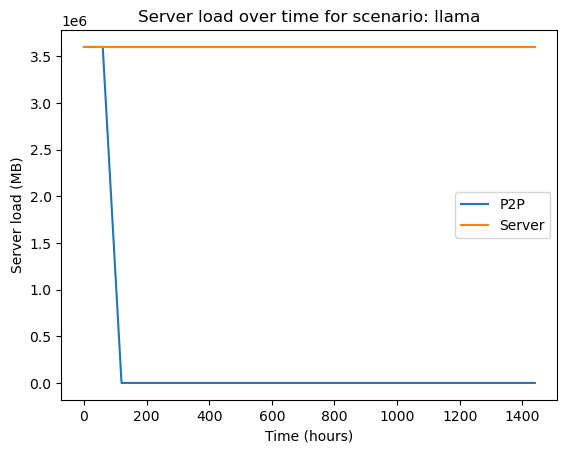

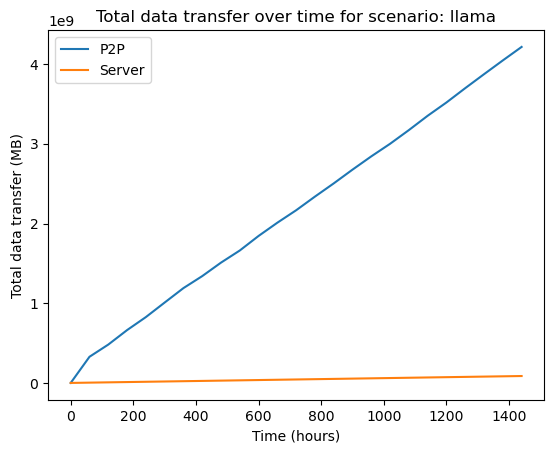

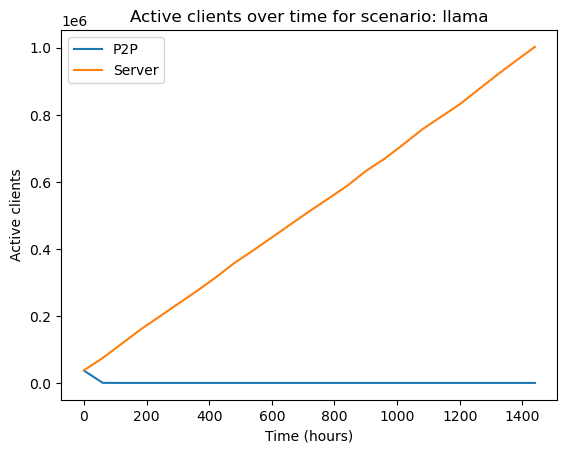

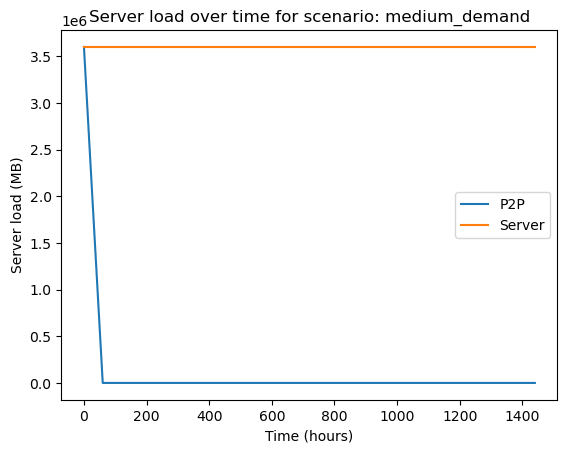

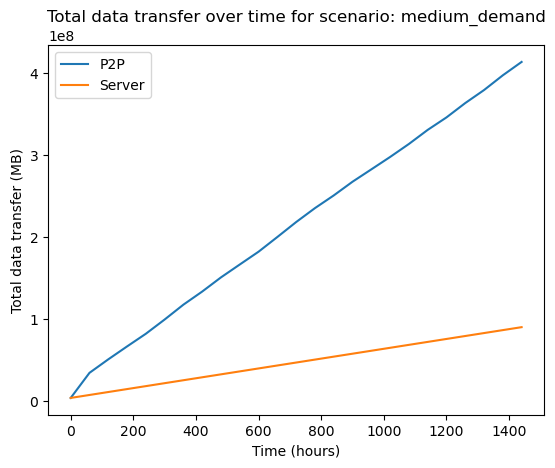

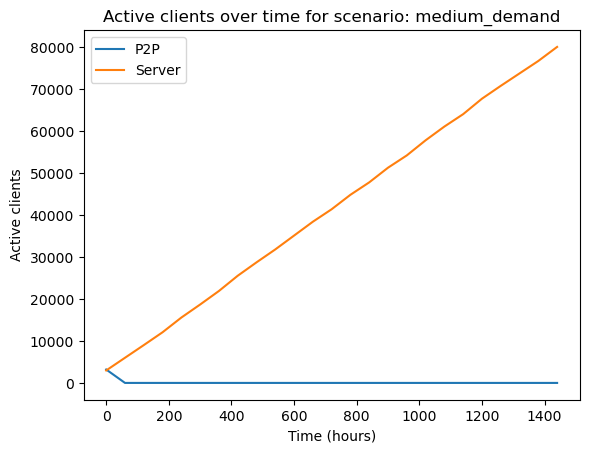

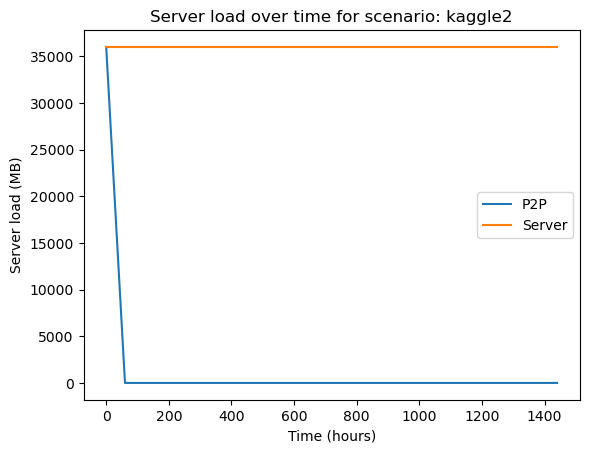

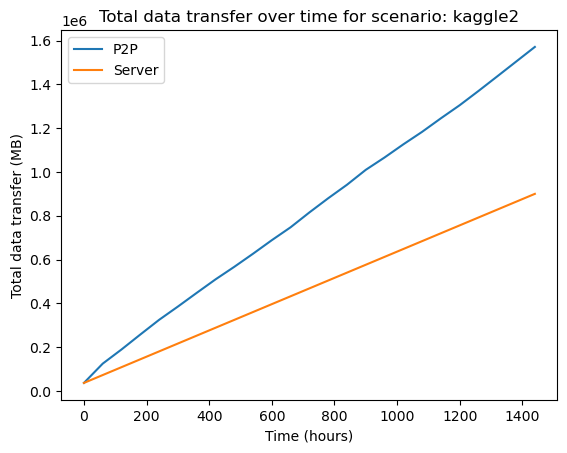

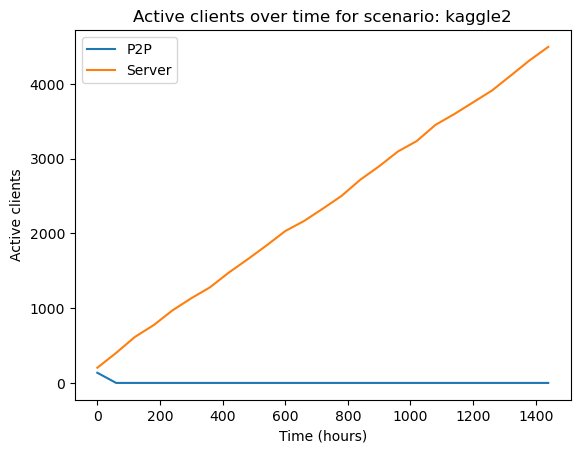

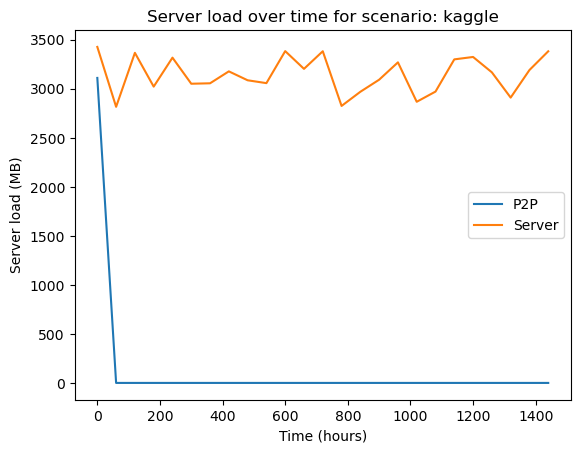

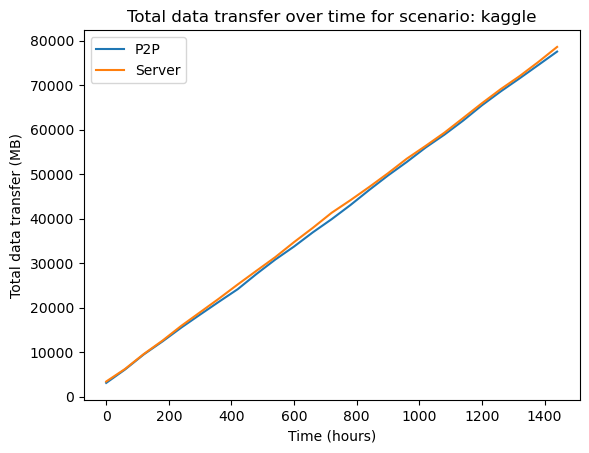

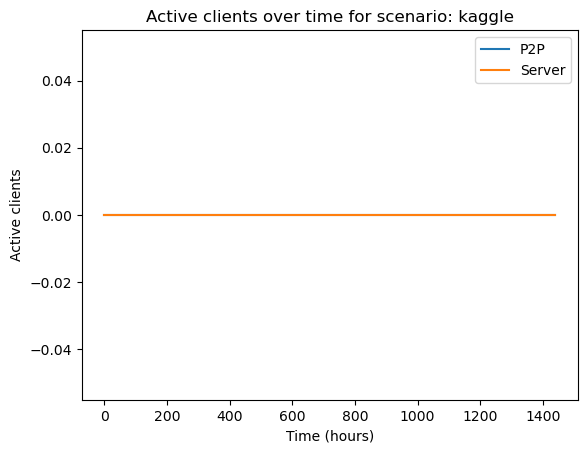

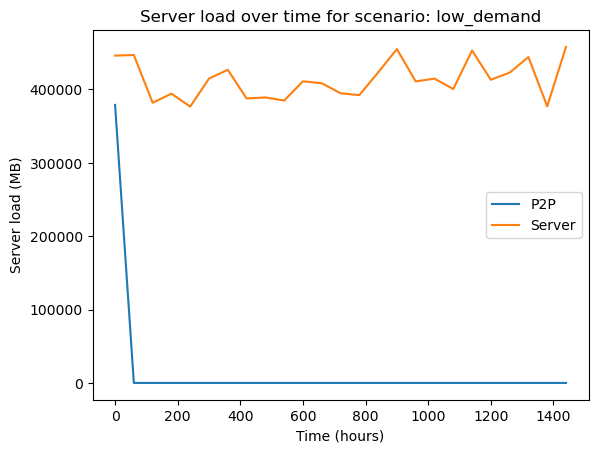

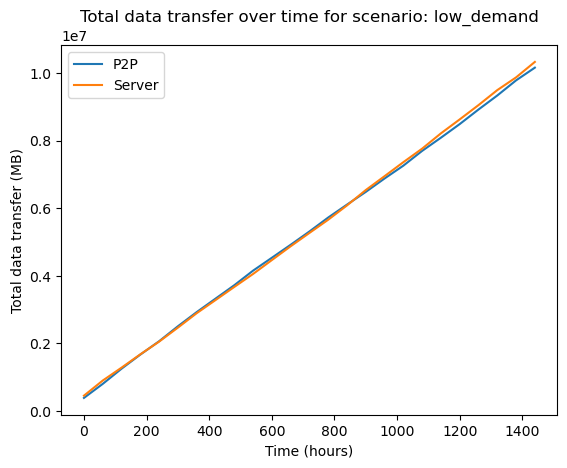

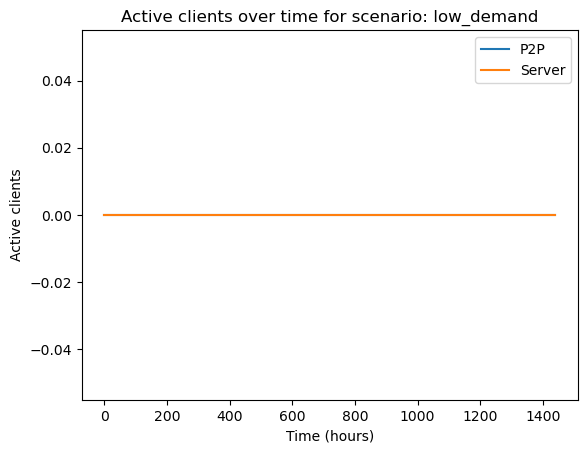

In [91]:
# draw graphs
import matplotlib.pyplot as plt

experiments = [
    {
        "name": "Server load",
        "data_point": "server_load",
        "y_label": "Server load (MB)",
        "title": "Server load over time",
    },
    {
        "name": "Total data transfer",
        "data_point": "total_data_transfer",
        "y_label": "Total data transfer (MB)",
        "title": "Total data transfer over time",
    },
    {
        "name": "Active clients",
        "data_point": "active_clients",
        "y_label": "Active clients",
        "title": "Active clients over time",
    },
]

for result in results:
    p2p_result_subset = result["p2p"][:25]
    server_result_subset = result["server"][:25]
    for experiment in experiments:
        plt.plot([data["time"]/60 for data in p2p_result_subset], [data[experiment["data_point"]] for data in p2p_result_subset], label="P2P")
        plt.plot([data["time"]/60 for data in server_result_subset], [data[experiment["data_point"]] for data in server_result_subset], label="Server")
        plt.xlabel("Time (hours)")
        plt.ylabel(experiment["y_label"])
        plt.title(experiment["title"]+" for scenario: "+result["scenario"])
        plt.legend()
        plt.show()

    # plot number of seeders
    # plt.plot([data["time"] for data in result["p2p"]], [data["seeders"] for data in result["p2p"]], label="P2P")
    # plt.plot([data["time"] for data in result["server"]], [data["seeders"] for data in result["server"]], label="Server")
    # plt.xlabel("Time (hours)")
    # plt.ylabel("Number of seeders")
    # plt.title("Number of seeders over time for scenario: "+result["scenario"])
    # plt.legend()
    # plt.show()
    # p2p_result_subset = result["p2p"][:25]
    # server_result_subset = result["server"][:25]
    # data_point = "total_data_transfer"
    # data_point = "server_load"

    # # plot network data transfer
    # plt.plot([data["time"] for data in p2p_result_subset], [data[data_point] for data in p2p_result_subset], label="P2P")
    # plt.plot([data["time"] for data in server_result_subset], [data[data_point] for data in server_result_subset], label="Server")
    # plt.xlabel("Time (hours)")
    # plt.ylabel("Network data transfer (MB)")
    # plt.title("Network data transfer over time for scenario: "+result["scenario"])
    # plt.legend()
    # plt.show()


Running test for scenario: 1
Running test for scenario: 10
Running test for scenario: 100
Running test for scenario: 1000
Running test for scenario: 10000
Running test for scenario: 100000
Running test for scenario: 1000000


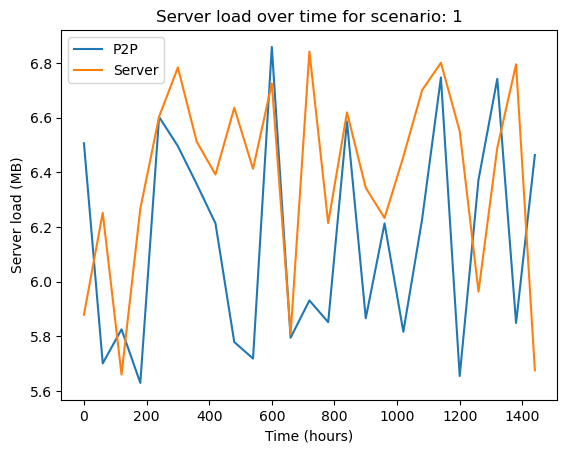

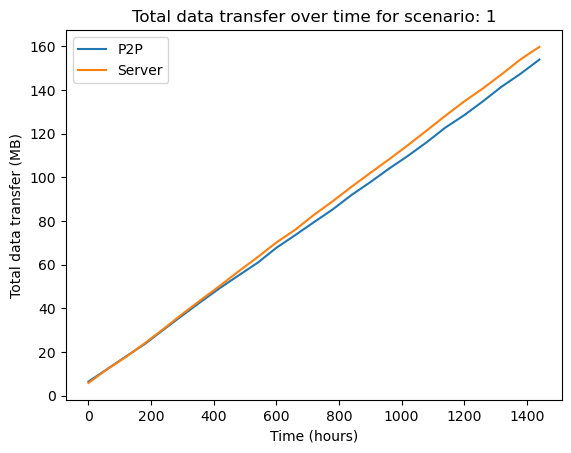

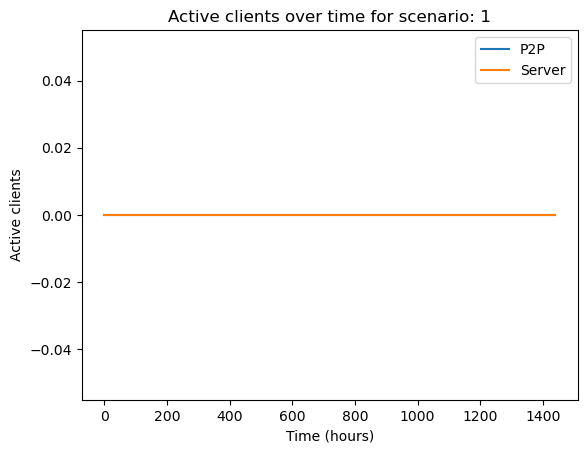

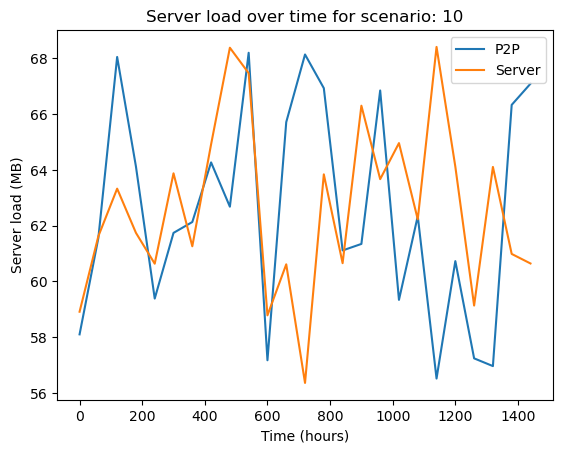

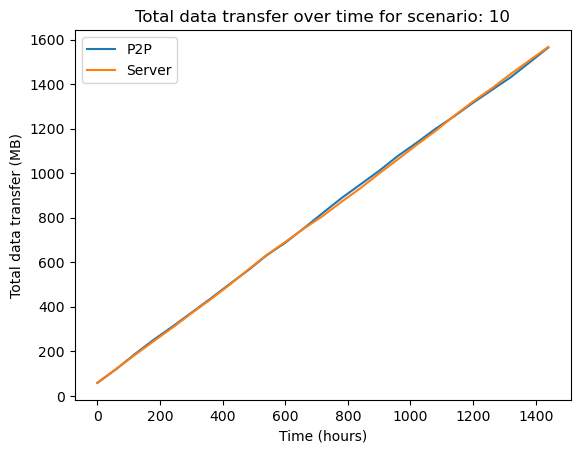

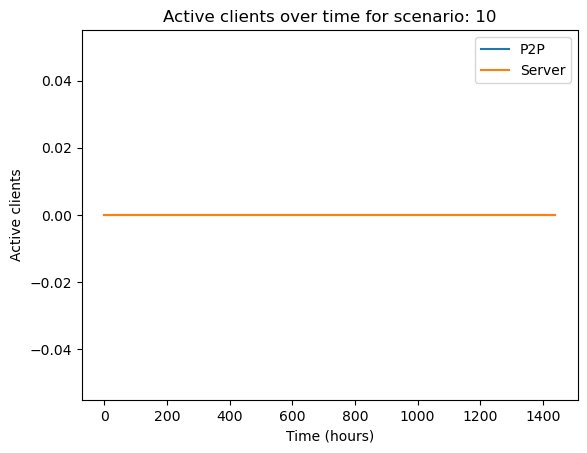

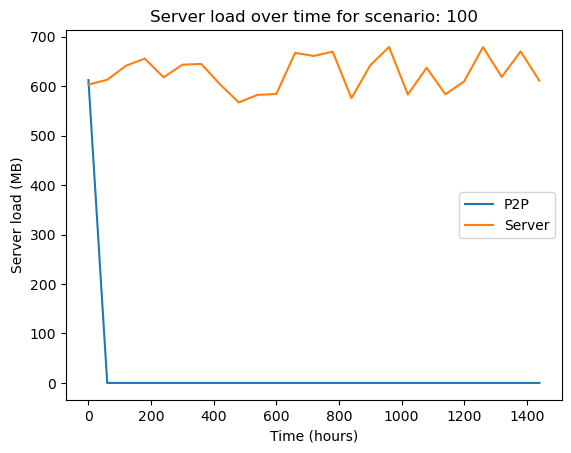

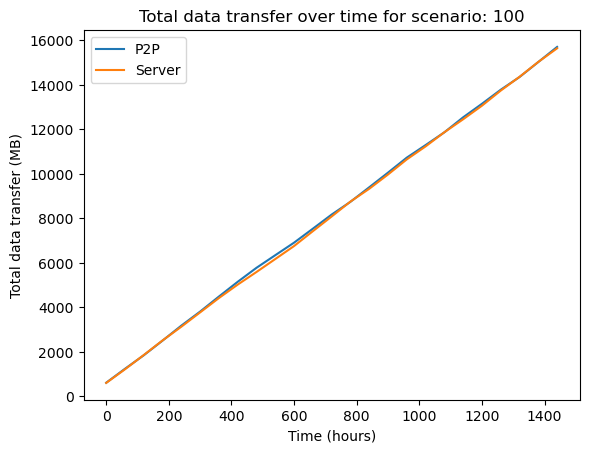

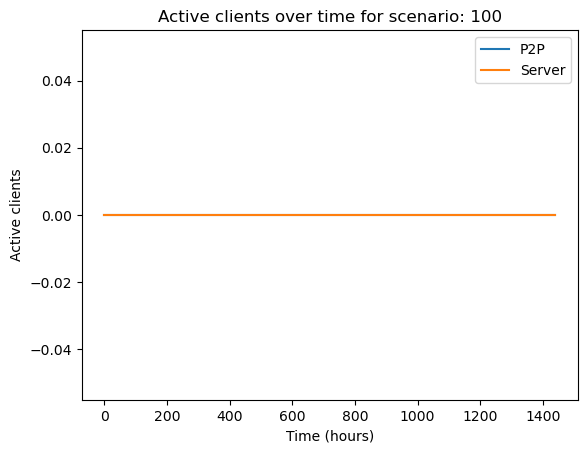

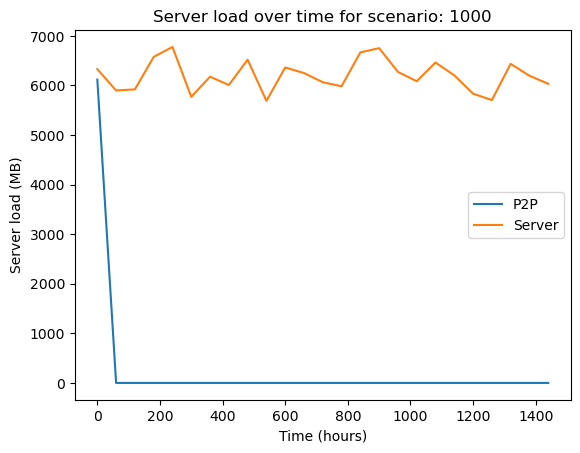

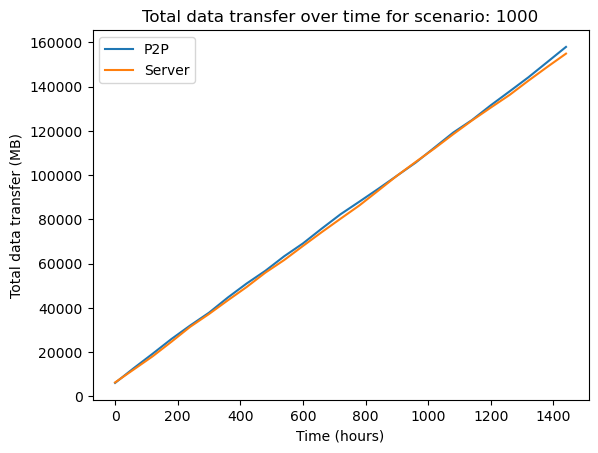

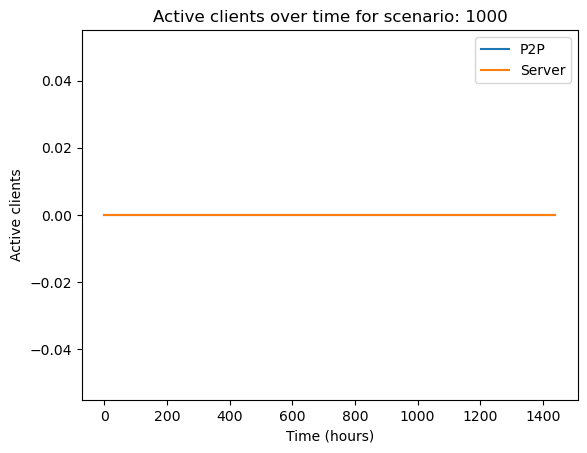

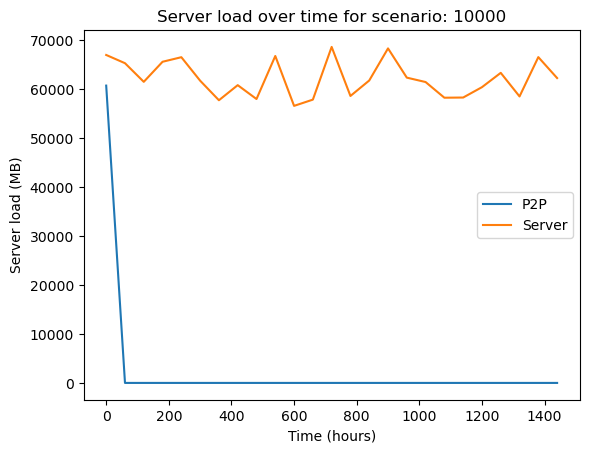

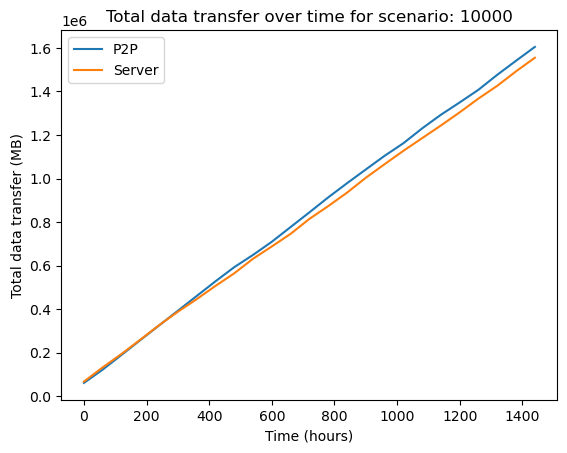

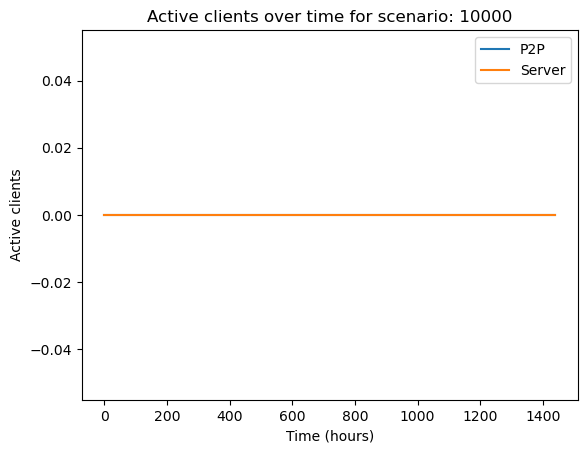

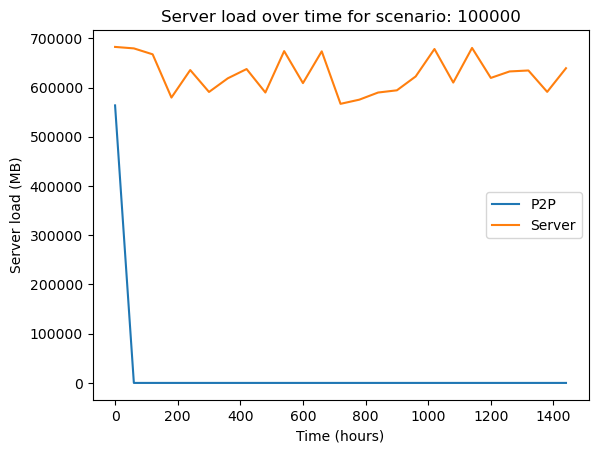

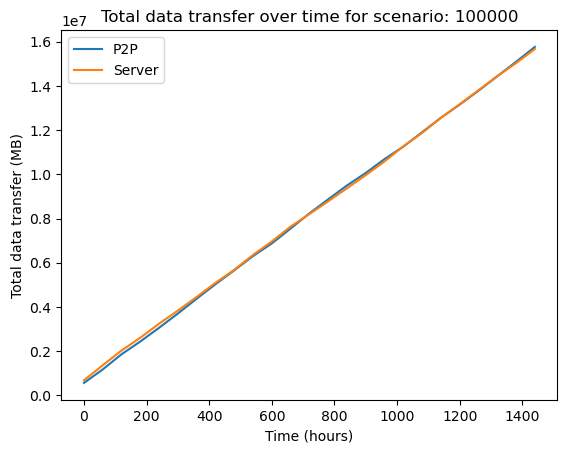

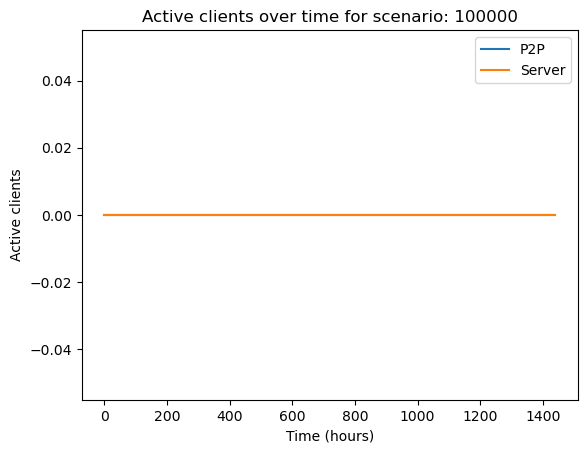

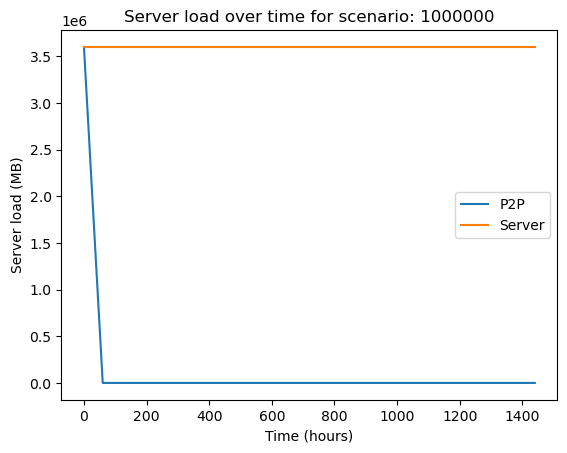

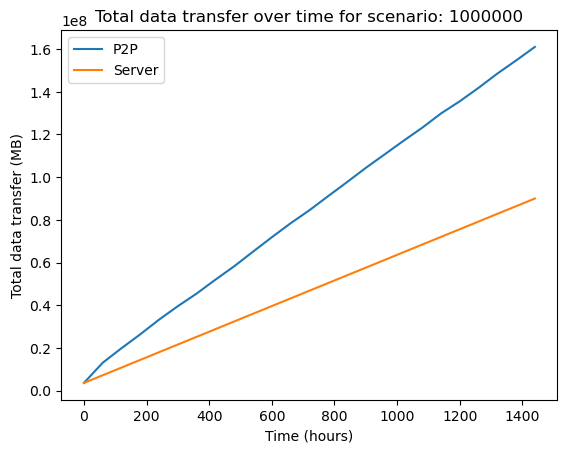

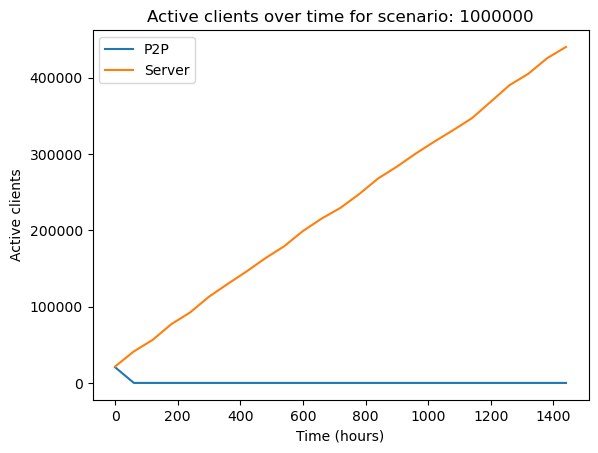

In [95]:
# run simulation for scenarios with low number of clients to high number of clients
# then plot the number of clients vs other metrics
scenarios = [1, 10, 100, 1000, 10000, 100000, 1000000]
new_results = []
base_scenario = {
    "download_size": 150, #mb
    "main_server_throughput": 1000, #mbps
    "main_server_client_throughput": 50, #mbps this is the throughput that the main server will limit the clients to
    "p2p_max_clients": 1000000000,
    "p2p_client_throughput_range": [1, 100], #mbps
    "p2p_average_throughput": 50, #mbps
    "daily_new_clients": 10000,
    "average_client_lifespan": 5*24*60*60, #seconds
    "average_share_ratio": 1.5,
}
for scenario in scenarios:
    print("Running test for scenario: "+str(scenario))
    base_scenario["daily_new_clients"] = scenario
    new_results.append(simulate_scenario_alt(base_scenario))

# plot number of clients vs other metrics
for i in range(len(scenarios)):
    result = new_results[i]
    p2p_result_subset = result["p2p"][:25]
    server_result_subset = result["server"][:25]
    for experiment in experiments:
        plt.plot([data["time"]/60 for data in p2p_result_subset], [data[experiment["data_point"]] for data in p2p_result_subset], label="P2P")
        plt.plot([data["time"]/60 for data in server_result_subset], [data[experiment["data_point"]] for data in server_result_subset], label="Server")
        plt.xlabel("Time (hours)")
        plt.ylabel(experiment["y_label"])
        plt.title(experiment["title"]+" for scenario: "+str(scenarios[i]))
        plt.legend()
        plt.show()